<a href="https://colab.research.google.com/github/Zardian18/Cars_generation_different_models/blob/master/VAE_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-23 08:49:17--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0.001s  

2024-01-23 08:49:18 (12.3 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers, activations
from helper import sample_batch, display, get_vector_from_label, add_vector_to_images, morph_faces
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

In [5]:
! kaggle datasets download -d markminerov/88500-car-images

100% 2.90G/2.91G [00:34<00:00, 152MB/s]
100% 2.91G/2.91G [00:34<00:00, 91.0MB/s]


In [ ]:
! unzip 88500-car-images.zip

In [7]:
train_data = utils.image_dataset_from_directory(
    "/content/out",
    labels= None,
    color_mode= "rgb",
    image_size=(32,32),
    batch_size=128,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)
train_data

Found 88560 files belonging to 1 classes.


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>

In [8]:
def preprocess(imgs):
  imgs = tf.cast(imgs, "float32")/255.0
  return imgs

train = train_data.map(lambda x: preprocess(x))

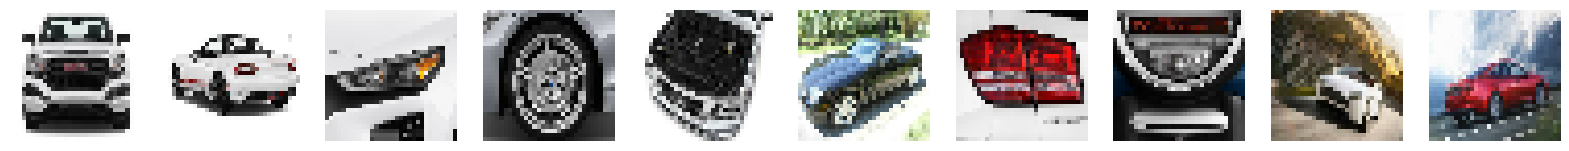

In [10]:
train_sample = sample_batch(train)
display(train_sample, cmap=None)

## Encoder

In [11]:
class Sampling(models.Model):
  def call(self, inputs):
    z_mean, z_log_var= inputs
    batch= tf.shape(z_mean)[0]
    dim= tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5*z_log_var)* epsilon

In [13]:
encoder_input= layers.Input(shape=(32,32,3), name="encoder_input")

x= layers.Conv2D(32, 3, strides=2, padding="same")(encoder_input)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(64, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(128, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(256, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x= layers.Conv2D(512, 3, strides=2, padding="same")(x)
x= layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

shape_before_flatten= x.shape[1:]

x= layers.Flatten()(x)
z_mean= layers.Dense(200, name="z_mean")(x)
z_log_var= layers.Dense(200, name="z_log_var")(x)
z= Sampling()([z_mean, z_log_var])

encoder= models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 16, 16, 32)           896       ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization_4 (Bat  (None, 16, 16, 32)           128       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)           0         ['batch_normalization_4[

## Decoder

In [14]:
decoder_input= layers.Input(shape=(200,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flatten))(decoder_input)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(512, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x= layers.LeakyReLU()(x)

decoder_output= layers.Conv2DTranspose(3, 3, strides=1, padding="same", activation="sigmoid")(x)

decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 512)               102912    
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 512)               0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 2, 2, 512)         2359808   
 anspose)                                                  

In [15]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                2000 * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            2000 * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [16]:
vae= VAE(encoder, decoder)

In [17]:
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0005))

In [18]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [19]:
!mkdir output

In [20]:
vae.fit(
    train,
    epochs=25,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=200),
    ],
)

Epoch 1/25
692/692 [==============================] - ETA: 0s - loss: 135.4520 - reconstruction_loss: 97.1605 - kl_loss: 16.3012

692/692 [==============================] - 134s 162ms/step - loss: 135.4203 - reconstruction_loss: 97.1605 - kl_loss: 16.3012
Epoch 2/25
692/692 [==============================] - ETA: 0s - loss: 96.9915 - reconstruction_loss: 79.7677 - kl_loss: 15.7263

692/692 [==============================] - 104s 149ms/step - loss: 96.9894 - reconstruction_loss: 79.7677 - kl_loss: 15.7263
Epoch 3/25
692/692 [==============================] - ETA: 0s - loss: 92.6634 - reconstruction_loss: 75.8891 - kl_loss: 16.1309

692/692 [==============================] - 103s 147ms/step - loss: 92.6624 - reconstruction_loss: 75.8891 - kl_loss: 16.1309
Epoch 4/25
692/692 [==============================] - ETA: 0s - loss: 90.6255 - reconstruction_loss: 73.5551 - kl_loss: 16.5619

692/692 [==============================] - 107s 152ms/step - loss: 90.6247 - reconstruction_loss: 73.5551 - kl_loss: 16.5619
Epoch 5/25
692/692 [==============================] - ETA: 0s - loss: 89.1798 - reconstruction_loss: 72.0866 - kl_loss: 16.8234

692/692 [==============================] - 103s 148ms/step - loss: 89.1794 - reconstruction_loss: 72.0866 - kl_loss: 16.8234
Epoch 6/25
692/692 [==============================] - ETA: 0s - loss: 88.0153 - reconstruction_loss: 70.9531 - kl_loss: 16.8942

692/692 [==============================] - 102s 146ms/step - loss: 88.0151 - reconstruction_loss: 70.9531 - kl_loss: 16.8942
Epoch 7/25
692/692 [==============================] - ETA: 0s - loss: 87.3132 - reconstruction_loss: 70.1484 - kl_loss: 16.9900

692/692 [==============================] - 107s 152ms/step - loss: 87.3129 - reconstruction_loss: 70.1484 - kl_loss: 16.9900
Epoch 8/25
692/692 [==============================] - ETA: 0s - loss: 86.7256 - reconstruction_loss: 69.3554 - kl_loss: 17.1247

692/692 [==============================] - 102s 146ms/step - loss: 86.7252 - reconstruction_loss: 69.3554 - kl_loss: 17.1247
Epoch 9/25
692/692 [==============================] - ETA: 0s - loss: 85.9219 - reconstruction_loss: 68.4920 - kl_loss: 17.2908

692/692 [==============================] - 107s 152ms/step - loss: 85.9217 - reconstruction_loss: 68.4920 - kl_loss: 17.2908
Epoch 10/25
692/692 [==============================] - ETA: 0s - loss: 85.3538 - reconstruction_loss: 67.8596 - kl_loss: 17.4243

692/692 [==============================] - 103s 147ms/step - loss: 85.3537 - reconstruction_loss: 67.8596 - kl_loss: 17.4243
Epoch 11/25
692/692 [==============================] - ETA: 0s - loss: 84.9293 - reconstruction_loss: 67.3271 - kl_loss: 17.4934

692/692 [==============================] - 105s 149ms/step - loss: 84.9291 - reconstruction_loss: 67.3271 - kl_loss: 17.4934
Epoch 12/25
692/692 [==============================] - ETA: 0s - loss: 84.5857 - reconstruction_loss: 66.9067 - kl_loss: 17.5708

692/692 [==============================] - 103s 148ms/step - loss: 84.5855 - reconstruction_loss: 66.9067 - kl_loss: 17.5708
Epoch 13/25
692/692 [==============================] - ETA: 0s - loss: 84.2453 - reconstruction_loss: 66.5407 - kl_loss: 17.6447

692/692 [==============================] - 104s 148ms/step - loss: 84.2452 - reconstruction_loss: 66.5407 - kl_loss: 17.6447
Epoch 14/25
692/692 [==============================] - ETA: 0s - loss: 83.8577 - reconstruction_loss: 66.1377 - kl_loss: 17.7065

692/692 [==============================] - 104s 149ms/step - loss: 83.8577 - reconstruction_loss: 66.1377 - kl_loss: 17.7065
Epoch 15/25
692/692 [==============================] - ETA: 0s - loss: 83.6586 - reconstruction_loss: 65.8782 - kl_loss: 17.7505

692/692 [==============================] - 103s 147ms/step - loss: 83.6585 - reconstruction_loss: 65.8782 - kl_loss: 17.7505
Epoch 16/25
692/692 [==============================] - ETA: 0s - loss: 83.5095 - reconstruction_loss: 65.5575 - kl_loss: 17.8201

692/692 [==============================] - 107s 152ms/step - loss: 83.5093 - reconstruction_loss: 65.5575 - kl_loss: 17.8201
Epoch 17/25
692/692 [==============================] - ETA: 0s - loss: 83.1294 - reconstruction_loss: 65.2984 - kl_loss: 17.8364

692/692 [==============================] - 109s 155ms/step - loss: 83.1294 - reconstruction_loss: 65.2984 - kl_loss: 17.8364
Epoch 18/25
692/692 [==============================] - ETA: 0s - loss: 83.0349 - reconstruction_loss: 65.0178 - kl_loss: 17.9077

692/692 [==============================] - 103s 147ms/step - loss: 83.0347 - reconstruction_loss: 65.0178 - kl_loss: 17.9077
Epoch 19/25
691/692 [============================>.] - ETA: 0s - loss: 82.7408 - reconstruction_loss: 64.8096 - kl_loss: 17.9126

692/692 [==============================] - 104s 148ms/step - loss: 82.7407 - reconstruction_loss: 64.8088 - kl_loss: 17.9131
Epoch 20/25
692/692 [==============================] - ETA: 0s - loss: 82.5347 - reconstruction_loss: 64.5298 - kl_loss: 17.9683

692/692 [==============================] - 104s 148ms/step - loss: 82.5347 - reconstruction_loss: 64.5298 - kl_loss: 17.9683
Epoch 21/25
692/692 [==============================] - ETA: 0s - loss: 82.3868 - reconstruction_loss: 64.3279 - kl_loss: 18.0197

692/692 [==============================] - 108s 153ms/step - loss: 82.3867 - reconstruction_loss: 64.3279 - kl_loss: 18.0197
Epoch 22/25
692/692 [==============================] - ETA: 0s - loss: 82.2635 - reconstruction_loss: 64.1834 - kl_loss: 18.0402

692/692 [==============================] - 104s 149ms/step - loss: 82.2635 - reconstruction_loss: 64.1834 - kl_loss: 18.0402
Epoch 23/25
692/692 [==============================] - ETA: 0s - loss: 82.0321 - reconstruction_loss: 63.8934 - kl_loss: 18.0876

692/692 [==============================] - 105s 150ms/step - loss: 82.0320 - reconstruction_loss: 63.8934 - kl_loss: 18.0876
Epoch 24/25
692/692 [==============================] - ETA: 0s - loss: 81.8417 - reconstruction_loss: 63.7000 - kl_loss: 18.1367

692/692 [==============================] - 103s 147ms/step - loss: 81.8417 - reconstruction_loss: 63.7000 - kl_loss: 18.1367
Epoch 25/25
692/692 [==============================] - ETA: 0s - loss: 81.8561 - reconstruction_loss: 63.5729 - kl_loss: 18.1734

692/692 [==============================] - 100s 143ms/step - loss: 81.8559 - reconstruction_loss: 63.5729 - kl_loss: 18.1734


In [21]:
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 1s 5ms/step
Example Images


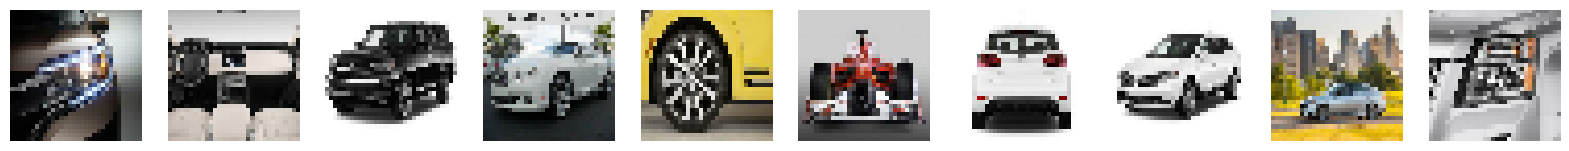

Recosntructed Images


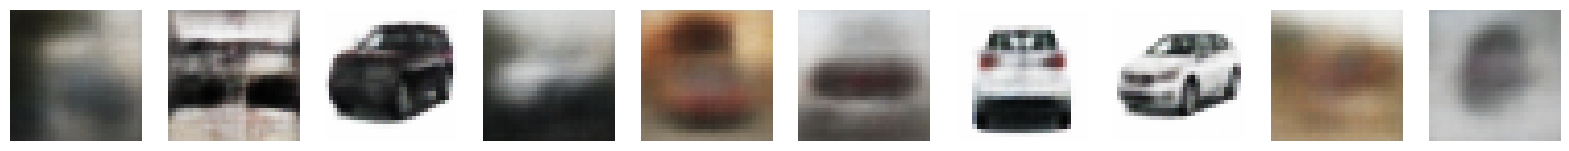

In [22]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example Images")
display(example_images)
print("Recosntructed Images")
display(reconstructions)

1/1 [==============================] - 0s 20ms/step


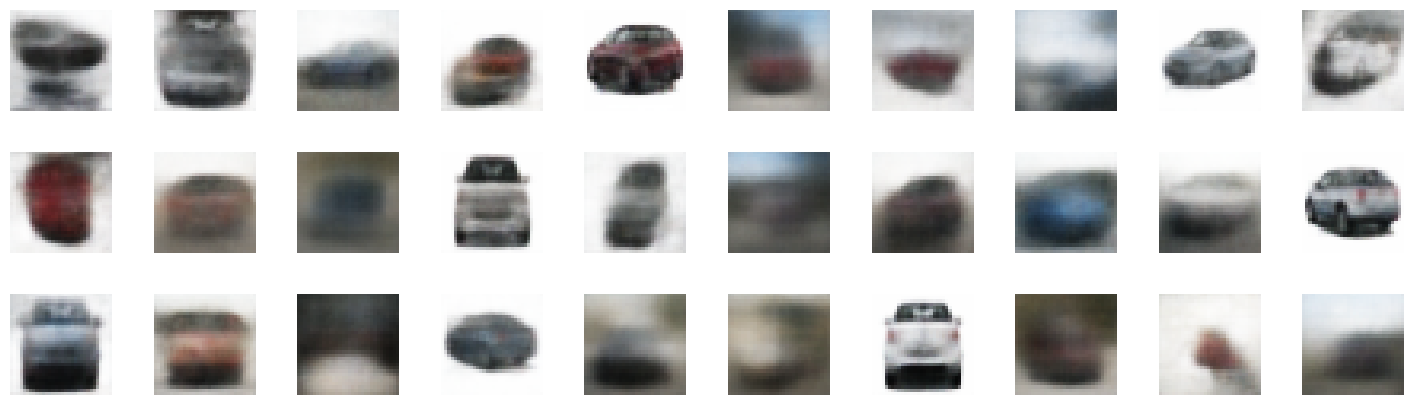

In [42]:
grid_width, grid_height = (10,3)
z_sample= np.random.normal(size=(grid_width*grid_height, 200)) # 10*3 new embeddings

reconstructions = decoder.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width*grid_height):
  ax= fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis(False)
  ax.imshow(reconstructions[i])

1/1 [==============================] - 0s 31ms/step


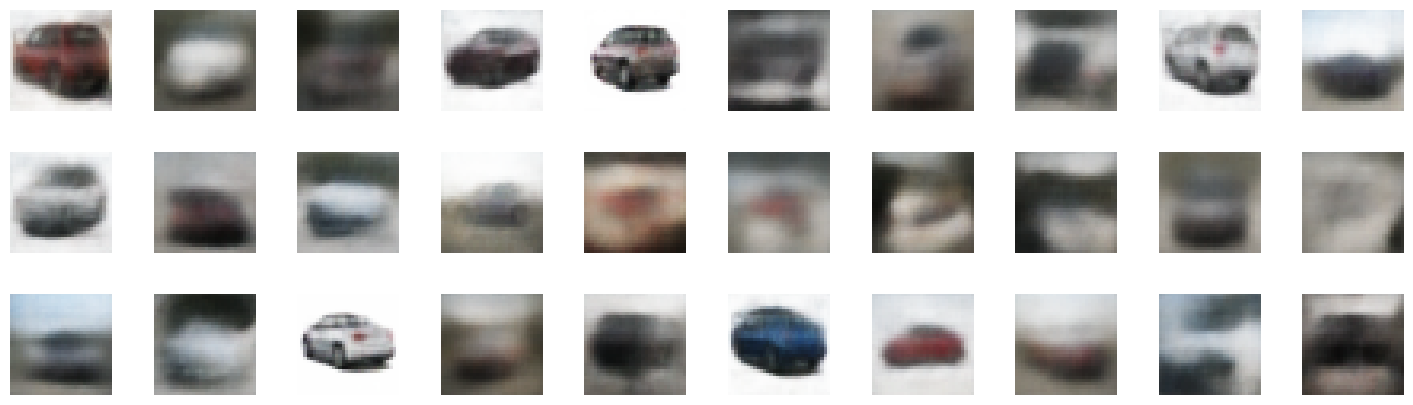

In [41]:
grid_width, grid_height = (10,3)
z_sample= np.random.normal(size=(grid_width*grid_height, 200)) # 10*3 new embeddings

reconstructions = decoder.predict(z_sample)

fig = plt.figure(figsize=(18,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width*grid_height):
  ax= fig.add_subplot(grid_height, grid_width, i+1)
  ax.axis(False)
  ax.imshow(reconstructions[i])